In [111]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

import seaborn as sns
import matplotlib.pyplot as plt

import time

In [2]:
movies = pd.read_csv('3b movies_GloVe.csv')
unprepared_movies = pd.read_csv('3b movies_GloVe.csv')
country_codes = pd.read_csv('country_codes.csv')
ratings = pd.read_csv('2 ratings.csv')

In [3]:
def get_numbers(str):
    """Return the integer numbers from a string in an array format."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').split()
    arr = [int(s) for s in arr if s.isdigit()]
    return arr

def get_country_codes(str):
    """Return the codes of the countries from a string."""
    arr = str.replace(',','').replace('{','').replace('}','').replace('[','').replace(']','').replace("'", "").split()
    arr = [s for s in arr if country_codes['Code'].str.contains(s).any()]
    return arr

def prepare_dataframe(movies):
    
    # Conversion
    movies['genres'] = movies['genres'].apply(lambda str: get_numbers(str))
    movies['production_companies'] = movies['production_companies'].apply(lambda str: get_numbers(str))
    movies['production_countries'] = movies['production_countries'].apply(lambda str: get_country_codes(str)) # This takes time
    
    # Get dummies
    mlb = MultiLabelBinarizer()
    genres = pd.DataFrame(mlb.fit_transform(movies['genres']), columns=mlb.classes)

    mlb = MultiLabelBinarizer()
    production_companies = pd.DataFrame(mlb.fit_transform(movies['production_companies']), columns=mlb.classes)

    mlb = MultiLabelBinarizer()
    production_countries = pd.DataFrame(mlb.fit_transform(movies['production_countries']), columns=mlb.classes)

    original_language = pd.get_dummies(movies['original_language'])
    
    # Rename the columns to unique names
    for i in range(genres.shape[1]):
        genres.rename(mapper={i : str(i) + '. genre'}, axis=1, inplace=True)
    
    for i in range(production_countries.shape[1]):
        production_countries.rename(mapper={i : str(i) + '. country'}, axis=1, inplace=True)
    
    movieids = movies['id']
    movies = movies.drop(['id', 'title'], axis=1)
    
    # production_companies, original languages, production countries are not used, because of huge running time
    numeric = movies.drop(['adult', 'genres', 'original_language', 'production_companies', 'production_countries'], axis=1)
    categorical = movies[['adult']].join(genres)
    
    # Scale the numeric values to (0, 1) interval
    scaler = MinMaxScaler()
    numeric = scaler.fit_transform(numeric)
    
    movievectors = pd.DataFrame(numeric).join(categorical)
    movievectors.index = movieids
    
    return movievectors

In [4]:
movies = prepare_dataframe(movies)

Recommend movies:

In [101]:
inputuser = 1

In [115]:
def similarity(inputuser=1, ratings=ratings):
    
    if inputuser not in ratings['userId']:
        return -1
    
    # Users and their ratings that have at least 1 common movie with input user
    reduced_ratings = ratings[ratings['movieId'].isin(ratings[ratings['userId'] == inputuser]['movieId'])]
    
    groups = reduced_ratings.groupby('userId')

    inputuserdata = groups.get_group(inputuser).drop('userId', axis=1)

    similarity_vector = []
    for user in reduced_ratings['userId'].unique():
        otheruserdata = groups.get_group(user).drop('userId', axis=1)

        # Distance
        ncommonmovies = inputuserdata['movieId'].isin(otheruserdata['movieId']).sum()

        # Common movies vector
        input = inputuserdata[inputuserdata['movieId'].isin(otheruserdata['movieId'])]['rating']
        other = otheruserdata[otheruserdata['movieId'].isin(inputuserdata['movieId'])]['rating']

        similarity = 1 - distance.cosine(input, other)
        similarity = (similarity + 1) / 2 # [-1..1] interval to [0..1]

        similarity = similarity * ncommonmovies
        similarity_vector.append(similarity)
        
    return similarity_vector

In [112]:
start = time.time()
similarity_vector = similarity(inputuser = 1, ratings = ratings)
end = time.time()
elapsed = end-start

In [113]:
elapsed

210.87516808509827

<Figure size 936x360 with 0 Axes>

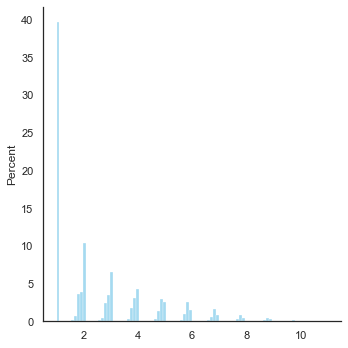

In [122]:
# Distribution of distances
sns.set_theme(style="white")
plt.figure(figsize=(13,5))

sns.displot(similarity_vector, stat='percent', color='skyblue')